<a href="https://colab.research.google.com/github/vifirsanova/W2V/blob/main/Firsanova_W2V_zachet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Автор: [Виктория Фирсанова](https://github.com/vifirsanova)

[Репозиторий](https://github.com/vifirsanova/W2V)

# Загрузка библиотек

In [1]:
# библиотека для цветного вывода
!pip install colorama

In [ ]:
# PoS-разметка
!pip install natasha

In [ ]:
from colorama import Fore, Style # цветной вывод
import json # работа с javascript object notation
import random # случайное перемешивание

from natasha import NewsMorphTagger, NewsEmbedding, Doc, Segmenter #PoS-разметка

import re # RegEx для токенизации
from collections import defaultdict # построение словаря 
import numpy as np # работа с массивами
import torch # работа с моделями машинного обучения
import torch.nn as nn # работа с тензорами

from torch.autograd import Variable # для обучения CBOW
from torch.optim import SGD # для обучения CBOW
import torch.nn.functional as F # для обучения CBOW

import copy # сохранить обученную модель
from torch.utils.data import DataLoader # для обучения Skip-Gram

from sklearn.decomposition import TruncatedSVD # для визуализации 
import matplotlib.pyplot as plt

# Загрузка корпуса

* [Корпус новостей газеты Московский комсомолец за 2020-2021 года.](https://github.com/vifirsanova/W2V/blob/main/corpus.json) 

* Собран автором в рамках семинарских занятий.

* Корпус загружен на GitHub с помощью терминала git с помощью следующего кода:

```
git clone git@github.com:vifirsanova/W2V.git
cd w2v
git add corpus.json
git commit -m "Add file"
git push
```



In [4]:
# подгружаем корпус из GitHub
!wget https://raw.githubusercontent.com/vifirsanova/W2V/main/corpus.json

--2021-12-19 10:12:47--  https://raw.githubusercontent.com/vifirsanova/W2V/main/corpus.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 92111843 (88M) [text/plain]
Saving to: ‘corpus.json’

corpus.json         100%[===================>]  87.84M   184MB/s    in 0.5s    

2021-12-19 10:12:49 (184 MB/s) - ‘corpus.json’ saved [92111843/92111843]



In [5]:
# сохраняем корпус в переменную
with open('corpus.json', encoding='utf-8', newline='') as json_file:
    data = json.load(json_file)

In [6]:
# образец данных корпуса
print(f"{Fore.RED}Образец данных корпуса:\n")
data['data'][0]

Образец данных корпуса:



{'date': '31.03.2020',
 'link': 'https://www.mk.ru/social/2020/03/31/minobrnauki-pereneslo-vstupitelnye-ekzameny-v-vuzy-izza-koronavirusa.html',
 'rubric': 'Общество',
 'text': '\nВ Минобрнауки РФ приняли решение перенести даты вступительных экзаменов в вузы из-за коронавируса, заявил глава ведомства Валерий Фальков в интервью «Россия 24».\nОн отметил, что в этом году число бюджетных мест было увеличено на 34 тысячи. Сейчас начался экономический спад, но менять стратегию в министерстве не намерены.\nРешение об увеличении бюджетных мест в вузах связано с ростом числа выпускников школ. Будет увеличено число мест на педагогическом и медицинском направлениях. Большой запрос на бюджетные места у регионов, подчеркнул Фальков.\nРанее власти перенесли даты ЕГЭ и ОГЭ.\nЧитайте также:\xa0Скворцова похвалила российский препарат от коронавируса\n\xa0\n\n',
 'time': '09:11',
 'title': 'Минобрнауки решило перенести вступительные экзамены в вузы из-за коронавируса'}

In [7]:
# собираем тексты из корпуса
full_dataset = []

for elem in data['data']:
    full_dataset.append(elem['text'])

# случайное перемешивание данных
random.shuffle(full_dataset)

# деление на обучающую (80% данных) и проверочную (20% данных) выборку
TRAIN_VAL_SPLIT = int(len(full_dataset) * 0.8)
train = full_dataset[:TRAIN_VAL_SPLIT]
val = full_dataset[TRAIN_VAL_SPLIT:]

print(f"{Fore.RED}Образец текста из выборки:{Style.RESET_ALL}\n", ''.join(train[0]))
print(f"{Fore.RED}Размер обучающей выборки:{Style.RESET_ALL} {len(train)} новостей, {sum([len(x.split()) for x in train])} слов, {sum([len(x) for x in train])} символов\
\n{Fore.RED}Размер проверочной выборки:{Style.RESET_ALL} {len(val)} новостей, {sum([len(x.split()) for x in val])} слов, {sum([len(x) for x in val])} символов")

Образец текста из выборки:
 
Врио главы Ненецкого автономного округа Юрий Бездудный заявил, что одной из причин принятия решения об объединении с Архангельской областью стали проблемы бюджета.
По словам главы региона, бюджет НАО рассчитан из цены на нефть в $57, в связи с чем под угрозой оказалось выполнение обязательств перед гражданами.
"Выход - по объединению двух экономик", - заявил он.


Размер обучающей выборки: 36736 новостей, 3878736 слов, 37181607 символов
Размер проверочной выборки: 9184 новостей, 971272 слов, 9366577 символов


# Разметка

Для частеречной разметки можно прописать собственный парсер либо использовать готовый. 

[Образец собственного парсера](https://colab.research.google.com/drive/19ZDb0FR6wO2zA26vYzJMf8xFkFqwBq72?usp=sharing). Работает на базе ConvNet.

Здесь для разметки используется библиотека [Natasha](https://github.com/natasha/natasha/tree/61d44032ca10612bd2b37444cdb50077402dd386).

In [ ]:
# преобразуем тексты из обучающей и проверочной выборок к виду объектов, подходящих для обработки с помощью библиотеки Natasha 
train_doc, val_doc = [Doc(x) for x in train], [Doc(x) for x in val]
print(f"{Fore.RED}Образец обработанного текста:{Style.RESET_ALL}", val_doc[0])

# инструмент для сегментации текстов
segmenter = Segmenter()
# сегментация обучающей выборки
for x in train_doc:
  x.segment(segmenter)
# сегментация проверочной выборки
for x in val_doc:
  x.segment(segmenter)

print(f"{Fore.RED}Образец сегментированного текста:{Style.RESET_ALL}", val_doc[5].tokens[0])

Образец обработанного текста: Doc(text='\nРоссийская «Партия пенсионеров» произвела расче...)
Образец сегментированного текста: DocToken(start=1, stop=16, text='Премьер-министр')


In [ ]:
# PoS-разметка
morph_tagger = NewsMorphTagger(NewsEmbedding())
# разметка обучающей выборки
for x in train_doc:
  x.tag_morph(morph_tagger)

# разметка проверочной выборки
for x in val_doc:
  x.tag_morph(morph_tagger)

print(f"{Fore.RED}Образец размеченного текста:{Style.RESET_ALL}", val_doc[5].tokens[0])

Образец размеченного текста: DocToken(start=1, stop=16, text='Премьер-министр', pos='NOUN', feats=<Anim,Nom,Masc,Sing>)


In [ ]:
# сохраним полученные данные для дальнейшего использования
# разметка обучающей выборки
# создаем словарь, где будут храниться размеченные данные
train_corp = {}
# для каждого текста обучающей выборки
for n in range(len(train_doc)):
  # сохраняем в словарь PoS-тег и морфологические характеристики слова
  for k in range(len(train_doc[n].tokens)):
    train_corp[train_doc[n].tokens[k].text] = [train_doc[n].tokens[k].pos, train_doc[n].tokens[k].feats]

# разметка проверочной выборки
# создаем словарь, где будут храниться размеченные данные
val_corp = {}
# для каждого текста проверочной выборки
for n in range(len(val_doc)):
  # сохраняем в словарь PoS-тег и морфологические характеристики слова
  for k in range(len(val_doc[n].tokens)):
    val_corp[val_doc[n].tokens[k].text] = [val_doc[n].tokens[k].pos, val_doc[n].tokens[k].feats]

print(f"{Fore.RED}Образец размеченного корпуса:{Style.RESET_ALL}", list(val_corp.items())[0])
print(f"{Fore.RED}Объем размеченного корпуса обучающей выборки:{Style.RESET_ALL}", len(train_corp))
print(f"{Fore.RED}Объем размеченного корпуса проверочной выборки:{Style.RESET_ALL}", len(val_corp))

Образец размеченного корпуса: ('Российская', ['ADJ', {'Case': 'Nom', 'Degree': 'Pos', 'Gender': 'Fem', 'Number': 'Sing'}])
Объем размеченного корпуса обучающей выборки: 194057
Объем размеченного корпуса проверочной выборки: 92561


In [ ]:
# сохраним размеченный корпус в отдельный файл, чтобы его можно было использовать повторно
with open('train_corp.json', 'w') as f:
    json.dump(train_corp, f, ensure_ascii=False)

with open('val_corp.json', 'w') as f:
    json.dump(val_corp, f, ensure_ascii=False)

# Модель Word2Vec

## Токенизация

In [10]:
# построим токенизатор, который приводит тексты к нижнему регистру и удаляет все символы, кроме букв и цифр
def tokenizer(text):
    """
    Токенизатор
    :text: текст для токенизации (str)
    :return: токенизированный текст (list)
    """
    tokens = re.compile(r'[\w\d]+').findall(text.lower())
    return [token for token in tokens if len(token)]


# функция для токенизации корпуса
def tokenize(corpus, tokenizer=tokenizer):
    """
    Токенизация
    :corpus: корпус текстов или датасет (list)
    :tokenizer: типа токенизатора (func)
    :return: токенизированный корпус/датасет (list)
    """
    return [tokenizer(text) for text in corpus]


# токенизируем
train_tokenized = tokenize(train)
val_tokenized = tokenize(val)
print(f"{Fore.RED}Образец токенизированного текста:{Style.RESET_ALL}\n", ' '.join(train_tokenized[0]))

Образец токенизированного текста:
 врио главы ненецкого автономного округа юрий бездудный заявил что одной из причин принятия решения об объединении с архангельской областью стали проблемы бюджета по словам главы региона бюджет нао рассчитан из цены на нефть в 57 в связи с чем под угрозой оказалось выполнение обязательств перед гражданами выход по объединению двух экономик заявил он


## Построение словаря

In [11]:
# загрузка стоп-слов из репозитория
!wget https://raw.githubusercontent.com/vifirsanova/W2V/main/swl.txt

--2021-12-19 10:20:14--  https://raw.githubusercontent.com/vifirsanova/W2V/main/swl.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10814 (11K) [text/plain]
Saving to: ‘swl.txt’

swl.txt             100%[===================>]  10.56K  --.-KB/s    in 0s      

2021-12-19 10:20:14 (78.0 MB/s) - ‘swl.txt’ saved [10814/10814]



In [17]:
# стоп-слова 
stop_words = []

with open('swl.txt', encoding='utf-8') as f:
    for word in f:
      stop_words.append(word[:-1])

print(f"{Fore.RED}Образец стоп-слов:{Style.RESET_ALL}", stop_words[6:13])


def build_vocab(data_tokenized, pad_word=None, stop_words=stop_words):
    freq_dict = defaultdict(int) # количество словоупотреблений в документах 
    doc_n = len(data_tokenized) # общее количество документов

    # посчитать количество словоупотреблений в документах 
    for text in data_tokenized:
        unique_text_tokens = set(text)
        for token in unique_text_tokens:
            freq_dict[token] += 1


    # удалить стоп-слова
    for word in list(freq_dict.keys()):
        if word in stop_words:
            freq_dict.pop(word)


    # удалить уникальные слова
    freq_dict = {word: count for word, count in freq_dict.items() if count > 1}

    # отсортировать слова по убыванию частоты
    sorted_freq_dict = sorted(freq_dict.items(),
                                reverse=True,
                                key=lambda x: x[1])

    # паддинг
    padded_freq_dict = [(pad_word, 0)] + sorted_freq_dict
    
    # обновить нумерацию слов
    word2id = {word: i for i, (word, _) in enumerate(padded_freq_dict)}

    # преобразуем частотный словарь к виду матриц чисел
    word2freq = np.array([count / doc_n for _, count in padded_freq_dict], dtype='float32')

    return word2id, word2freq


# строим словарь для обучающей выборки
vocabulary, word_doc_freq = build_vocab(train_tokenized, pad_word='<PAD>', stop_words=stop_words)

print(f"{Fore.RED}Размер словаря:{Style.RESET_ALL} {len(vocabulary)}")
print(f"{Fore.RED}Образец словаря{Style.RESET_ALL}\n", list(vocabulary.items())[:10])

Образец стоп-слов: ['абы', 'авось', 'ага', 'аж', 'аз', 'ай', 'ай-ай-ай']
Размер словаря: 85915
Образец словаря
 [('<PAD>', 0), ('этом', 1), ('а', 2), ('россии', 3), ('ранее', 4), ('заявил', 5), ('словам', 6), ('время', 7), ('будет', 8), ('коронавируса', 9)]


## Векторизация

In [18]:
def texts2ids(data_tokenized, word2id):
    return [[word2id[token] for token in text if token in word2id]
            for text in data_tokenized]

# конвертация
train_token_ids = texts2ids(train_tokenized, vocabulary)
val_token_ids = texts2ids(val_tokenized, vocabulary)

print(f"{Fore.RED}Образец токенизированного текста{Style.RESET_ALL}\n", 
      ' '.join(train_tokenized[0][:5]))
print(f"{Fore.RED}Образец числовых представлений для этого текста{Style.RESET_ALL}\n", 
      ''.join(str(train_token_ids[0][:3])))
n1, n2, n3 = train_token_ids[0][0], train_token_ids[0][1], train_token_ids[0][2]
print(f"{Fore.RED}Расшифровка с помощью словаря{Style.RESET_ALL}\n", list(vocabulary.items())[n1], 
      list(vocabulary.items())[n2], list(vocabulary.items())[n3])

Образец токенизированного текста
 врио главы ненецкого автономного округа
Образец числовых представлений для этого текста
 [2744, 193, 17939]
Расшифровка с помощью словаря
 ('врио', 2744) ('главы', 193) ('ненецкого', 17939)


## Паддинг

In [21]:
# паддинг последовательностей (текстов):
# мы задаем длину n для последовательностей обучающих данных,
# обрезаем все тексты, которые превышают эту длину
# и заполняем нулями все тексты, длина которых ниже заданной длины

class PaddedSequenceDataset():
    def __init__(self, data, targets, out_len=100, pad_value=0):
        self.data = data
        self.targets = targets
        self.out_len = out_len
        self.pad_value = pad_value

    def __len__(self):
        return len(self.data)

    def ensure_length(self, txt, out_len, pad_value):
        if len(txt) < out_len:
            txt = list(txt) + [pad_value] * (out_len - len(txt))
        else:
            txt = txt[:out_len]
        return txt

    def __getitem__(self, item):
        txt = self.data[item]
        txt = self.ensure_length(txt, self.out_len, self.pad_value)
        txt = torch.tensor(txt, dtype=torch.long)
        target = torch.tensor(self.targets[item], dtype=torch.long)

        return txt, target


# максимальная длина последовательности
MAX_SENTENCE_LEN = 50

# применить паддинг
train_dataset = PaddedSequenceDataset(train_token_ids,
                                      np.zeros(len(train_token_ids)),
                                      out_len=MAX_SENTENCE_LEN)
val_dataset = PaddedSequenceDataset(val_token_ids,
                                     np.zeros(len(val_token_ids)),
                                     out_len=MAX_SENTENCE_LEN)

print(f"{Fore.RED}Образец числовых представлений для текста из выборки{Style.RESET_ALL}\n", 
      ''.join(str(train_token_ids[0])))
print(f"{Fore.RED}\nТо же после применения паддинга{Style.RESET_ALL}\n", train_dataset[0])

Образец числовых представлений для текста из выборки
 [2744, 193, 17939, 9979, 1486, 1233, 33681, 5, 357, 1739, 3586, 565, 15736, 7637, 17109, 346, 721, 1816, 6, 193, 400, 3126, 27945, 15105, 852, 1059, 1828, 44, 2770, 504, 4610, 4156, 2811, 2303, 30451, 218, 19926, 5]

То же после применения паддинга
 (tensor([ 2744,   193, 17939,  9979,  1486,  1233, 33681,     5,   357,  1739,
         3586,   565, 15736,  7637, 17109,   346,   721,  1816,     6,   193,
          400,  3126, 27945, 15105,   852,  1059,  1828,    44,  2770,   504,
         4610,  4156,  2811,  2303, 30451,   218, 19926,     5,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0]), tensor(0))


## Модель. Обучение

### CBOW

Continuous bag of words:
* модель получает на вход последовательно наборы слов из текста
* порядок слов в контексте не важен

Реализация: https://github.com/smafjal/continuous-bag-of-words-pytorch/blob/master/cbow_model_pytorch.py

In [31]:
# параметры модели
CONTEXT_SIZE = 3
EMBEDDING_DIM = 100
EPOCHS = 10

In [38]:
class CBOW(nn.Module):
    """
        vocab_size: размер обучающего словаря
        embedding_size: размер вектора (эмбеддинга)
        context_size: размер конекстного окна
        word_idx: вектора слова (созданные на шаге векторизации)
        vocab: словарь обучающей выборки
    """
    def __init__(self, vocab_size, embedding_size, context_size):
        super(CBOW, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.context_size = context_size
        self.embeddings = nn.Embedding(self.vocab_size, self.embedding_size)
        # вектор = context_size*2*embedding_size
        self.lin1 = nn.Linear(self.context_size * 2 * self.embedding_size, 512)
        self.lin2 = nn.Linear(512, self.vocab_size)
    
    def forward(self, inp):
        out = self.embeddings(inp).view(1, -1)
        out = out.view(1, -1)
        out = self.lin1(out)
        out = F.relu(out)
        out = self.lin2(out)
        out = F.log_softmax(out, dim=1)
        return out
    
    def get_word_vector(self, word_idx):
        word = Variable(torch.LongTensor([word_idx]))
        return self.embeddings(word).view(1, -1)

def train_cbow(data, vocab, word_to_idx):
    cbow = CBOW(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
    
    nll_loss = nn.NLLLoss()  # функция потерь
    optimizer = SGD(cbow.parameters(), lr=0.001) # оптимизация 
        
    for epoch in range(EPOCHS):
        total_loss = 0
        for context, target in data:            
            inp_var = Variable(torch.LongTensor([word_to_idx[word] for word in context]))
            target_var = Variable(torch.LongTensor([word_to_idx[target]]))
                        
            cbow.zero_grad()
            log_prob = cbow(inp_var)
            loss = nll_loss(log_prob, target_var)
            loss.backward()
            optimizer.step()
            total_loss += loss.data
        
    return cbow

def test_cbow(cbow, vocab, word_to_idx):

    word_1 = vocab[2]
    word_2 = vocab[3]
    
    word_1_vec = cbow.get_word_vector(word_to_idx[word_1])
    word_2_vec = cbow.get_word_vector(word_to_idx[word_2])
    
    word_similarity = (word_1_vec.dot(word_2_vec) / (torch.norm(word_1_vec) * torch.norm(word_2_vec))).data.numpy()[0]
    print("Similarity between '{}' & '{}' : {:0.4f}".format(word_1, word_2, word_similarity))

In [ ]:
# обучение
def main():

    data = list()
    for i in range(CONTEXT_SIZE, len(train_str) - CONTEXT_SIZE):
        data_context = list()
        for j in range(CONTEXT_SIZE):
            data_context.append(train_str[i - CONTEXT_SIZE + j])
        
        for j in range(1, CONTEXT_SIZE + 1):
            data_context.append(train_str[i + j])
        data_target = train_str[i]
        data.append((data_context, data_target))
 
    unique_vocab = list(set(train_str))
    
    word_to_idx = {w: i for i, w in enumerate(unique_vocab)}
    # обучаем
    cbow = train_cbow(data, unique_vocab, word_to_idx)
    # тестируем модель
    test_cbow(cbow, unique_vocab, word_to_idx)

if __name__ == "__main__":
    main()

### SkipGram

* предсказываем соседние слова по центральному слову
* Negative Sampling - максимизируем сумму вероятностей двух событий

Реализация: https://github.com/Samsung-IT-Academy/stepik-dl-nlp

In [ ]:
# побочная функция создает квадратную матрицу
# потребуется для создания маски для обучения модели
def make_diag_mask(size, radius):
    idxs = torch.arange(size)
    abs_idx_diff = (idxs.unsqueeze(0) - idxs.unsqueeze(1)).abs()
    mask = ((abs_idx_diff <= radius) & (abs_idx_diff > 0)).float()
    return mask


# модель Skip Gram Negative Sampling
class SkipGramNegativeSampling(nn.Module):
    def __init__(self, vocab_size, emb_size, sentence_len, radius=3, negative_samples_n=30):
        super().__init__()
        self.vocab_size = vocab_size
        self.negative_samples_n = negative_samples_n

        self.center_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)
        self.center_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.center_emb.weight.data[0] = 0

        self.context_emb = nn.Embedding(self.vocab_size, emb_size, padding_idx=0)        
        self.context_emb.weight.data.uniform_(-1.0 / emb_size, 1.0 / emb_size)
        self.context_emb.weight.data[0] = 0

        self.positive_sim_mask = make_diag_mask(sentence_len, radius)

    def forward(self, sentences):
        batch_size = sentences.shape[0]
        center_embeddings = self.center_emb(sentences)  # Batch x MaxSentLength x EmbSize

        # оценить сходство с соседними словами
        positive_context_embs = self.context_emb(sentences).permute(0, 2, 1)  # Batch x EmbSize x MaxSentLength
        positive_sims = torch.bmm(center_embeddings, positive_context_embs)  # Batch x MaxSentLength x MaxSentLength
        positive_probs = torch.sigmoid(positive_sims)

        # увеличить оценку вероятности совместной встречаемости для пар слов
        positive_mask = self.positive_sim_mask.to(positive_sims.device)
        positive_loss = F.binary_cross_entropy(positive_probs * positive_mask,
                                               positive_mask.expand_as(positive_probs))

        # выбрать случайные "отрицательные" слова
        negative_words = torch.randint(1, self.vocab_size,
                                       size=(batch_size, self.negative_samples_n),
                                       device=sentences.device)  # Batch x NegSamplesN
        negative_context_embs = self.context_emb(negative_words).permute(0, 2, 1)  # Batch x EmbSize x NegSamplesN
        negative_sims = torch.bmm(center_embeddings, negative_context_embs)  # Batch x MaxSentLength x NegSamplesN
        
        # уменьшить оценку вероятности совместной встречаемости для пар слов
        negative_loss = F.binary_cross_entropy_with_logits(negative_sims,
                                                           negative_sims.new_zeros(negative_sims.shape))

        return positive_loss + negative_loss


# фиктивная функция потерь
def no_loss(pred, target):
    return pred

In [ ]:
# обучение

# функция для сохранения обученной модели
def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError()


def train_and_eval(model, train_dataset, val_dataset, loss_func,
                   lr=1e-4, epochs=10, batch_size=32,
                   device=None, early_stopping_patience=10, l2=0,
                   max_batches_per_epoch_train=10000,
                   max_batches_per_epoch_val=1000,
                   data_loader=DataLoader,
                   optimizer=None,
                   lr_scheduler=None,
                   shuffle_train=True,
                   dataloader_workers_n=0):
    """
    Цикл для обучения и оценки модели
    :model: модель для обучения (torch.nn.Module)
    :train_dataset: обучающая выборка (torch.utils.data.Dataset)
    :val_dataset: проверочная выборка (torch.utils.data.Dataset)
    :loss_func: функция потерь (func)
    :lr: скорость обучения (float)
    :epochs: количество эпох обучения (int)
    :batch_size: размер батча (int)
    :device: cuda/cpu (str)
    :early_stopping_patience: наибольшее количество эпох, в течение которых допускается
        отсутствие улучшения модели (int)
    :l2: коэффициент L2-регуляризации (int)
    :max_batches_per_epoch_train: максимальное количество итераций на одну эпоху обучения (int)
    :max_batches_per_epoch_val: максимальное количество итераций на одну эпоху валидации (int)
    :data_loader: преобразует датасет в батчи (torch.utils.data.DataLoader)
    :optimizer: оптимизатор (torch.optim.optimizer)
    :lr_scheduler: задает скорость обучения (torch.optim.lr_scheduler)
    :shuffle_train: перемешать данные в обучающей выборке (Bool)
    :return: среднее значение функции потерь на валидации на лучшей эпохе, лучшая модель (tuple)
    """
    device = torch.device(device)
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2)
    lr_scheduler = lr_scheduler(optimizer)
    train_dataloader = data_loader(train_dataset, batch_size=batch_size, shuffle=shuffle_train,
                                        num_workers=dataloader_workers_n)
    val_dataloader = data_loader(val_dataset, batch_size=batch_size, shuffle=False,
                                      num_workers=dataloader_workers_n)

    best_val_loss = float('inf')
    best_epoch = 0
    best_model = copy.deepcopy(model)

    for epoch in range(epochs):
        try:
            print(f"Эпоха {epoch}")

            model.train()
            mean_train_loss = 0
            train_batches_n = 0
            for batch_i, (batch_x, batch_y) in enumerate(train_dataloader):
                if batch_i > max_batches_per_epoch_train:
                    break

                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)

                pred = model(batch_x)
                loss = loss_func(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1

            mean_train_loss /= train_batches_n
            print(f"Mean train loss = {mean_train_loss}")


            # После каждой эпохи качество модели оценивается по проверочной выборке
            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_i, (batch_x, batch_y) in enumerate(val_dataloader):
                    if batch_i > max_batches_per_epoch_val:
                        break

                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x)
                    loss = loss_func(pred, batch_y)

                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n
            print(f"Mean val loss = {mean_val_loss}")

            if mean_val_loss < best_val_loss:
                best_epoch = epoch
                best_val_loss = mean_val_loss
                best_model = copy.deepcopy(model)
            elif epoch - best_epoch > early_stopping_patience:
                print("Early stopping")
                break

            if lr_scheduler is not None:
                lr_scheduler.step(mean_val_loss)

            print()
            
        except KeyboardInterrupt:
            break
        except Exception as ex:
            print(ex)
            break

    return best_val_loss, best_model

skip = SkipGramNegativeSampling(vocab_size=len(vocabulary), emb_size=100, sentence_len=MAX_SENTENCE_LEN, radius=3, negative_samples_n=30)

best_val_loss, best_model = train_and_eval(model=skip,
                                           train_dataset,
                                           val_dataset,
                                           no_loss,
                                           lr=1e-2,
                                           epochs=5,
                                           batch_size=4,
                                           device='cpu',
                                           early_stopping_patience=5,
                                           max_batches_per_epoch_train=2000,
                                           max_batches_per_epoch_val=len(val_dataset),
                                           lr_scheduler=lambda optim: torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=1, verbose=True))

## Оценка близости

### Косинусное сходство

In [ ]:
class Word2Vec:
    def __init__(self, embeddings, word2id):
        self.embeddings = embeddings
        self.embeddings /= (np.linalg.norm(self.embeddings, ord=2, axis=-1, keepdims=True) + 1e-4)
        self.word2id = word2id
        self.id2word = {i: w for w, i in word2id.items()}


    def similar(self, word, num=10):
        """
        Функция находит наиболее похожие слова на данное (в основе - функция get_similar)
        :word: слово для анализа (str)
        :num: количество сходных слов для отображения (int)
        :return: num кортежей вида ('аналогичное слово' (str), вероятность сходства (0 <= float <= 1)) (list)
        """
        return self.get_similar(self.get_vector(word), num=num)


    def get_similar(self, vec, num=10):
        """
        Функция находит наиболее похожие вектора на данный
        :vec: вектор слова для анализа (numpy.ndarray)
        :num: количество сходных слов для отображения (int)
        :return: num кортежей вида ('аналогичное слово' (str), вероятность сходства (0 <= float <= 1)) (list)
        """
        similarities = (self.embeddings * vec).sum(-1) # сходные слова
        top_similar = np.argpartition(-similarities, num, axis=0)[:num]
        result = [(self.id2word[i], similarities[i]) for i in top_similar] # список кортежей
        result.sort(key=lambda x: -x[1]) # сортировка результата по убыванию
        return result


    def get_vector(self, word):
        if word not in self.word2id:
            raise ValueError('Неизвестное слово "{}"'.format(word))
        return self.embeddings[self.word2id[word]]


    def get_vectors(self, *words):
        word_ids = [self.word2id[i] for i in words]
        vectors = np.stack([self.embeddings[i] for i in word_ids], axis=0)
        return vectors


cbow_embeddings = Word2Vec(cbow.center_emb.weight.detach().cpu().numpy(), vocabulary)
skip_embeddings = Word2Vec(skip.center_emb.weight.detach().cpu().numpy(), vocabulary)

In [ ]:
# косинусное сходство для SkipGram
cbow_embeddings.similar('коронавирус')

[('коронавирус', 0.99979997),
 ('covid', 0.6591861),
 ('19', 0.6286661),
 ('тест', 0.6116188),
 ('положительным', 0.6109684),
 ('диагнозом', 0.57951033),
 ('заболевания', 0.5698585),
 ('пневмония', 0.5659813),
 ('пациентов', 0.55714273),
 ('типа', 0.5552652)]

In [ ]:
# косинусное сходство для CBOW
cbow.wv.most_similar('коронавирус')

[('вирус', 0.4928317070007324),
 ('инфекцию', 0.4871097505092621),
 ('подтвердился', 0.4787070155143738),
 ('тест', 0.4632793664932251),
 ('грипп', 0.44875916838645935),
 ('пневмонию', 0.445293128490448),
 ('теста', 0.4446257948875427),
 ('положительным', 0.4353533983230591),
 ('коронавирусную', 0.4322010576725006),
 ('пцр', 0.4312904477119446)]

### Евклидово расстояние

In [ ]:
# примеры для CBOW
euc_dist1 = np.linalg.norm(cbow.wv['коронавирус'] - cbow.wv['инфекция'])
euc_dist2 = np.linalg.norm(cbow.wv['коронавирус'] - cbow.wv['автомобиль'])
print(euc_dist1)
print(euc_dist2)

3.2005703
4.9440084


In [ ]:
# примеры для SkipGram
euc_dist1 = np.linalg.norm(word2vec.wv['коронавирус'] - word2vec.wv['инфекция'])
euc_dist2 = np.linalg.norm(word2vec.wv['коронавирус'] - word2vec.wv['автомобиль'])
print(euc_dist1)
print(euc_dist2)

6.9063272
7.9494586


# Коллокаты

In [ ]:
# подгружаем размеченные корпуса из GitHub
# обучающая выборка
!wget https://raw.githubusercontent.com/vifirsanova/W2V/main/train_corp.json
# проверочная выборка
!wget https://raw.githubusercontent.com/vifirsanova/W2V/main/val_corp.json

--2021-12-18 21:21:14--  https://raw.githubusercontent.com/vifirsanova/W2V/main/train_corp.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19711543 (19M) [text/plain]
Saving to: ‘train_corp.json.1’

train_corp.json.1   100%[===================>]  18.80M  --.-KB/s    in 0.1s    

2021-12-18 21:21:14 (168 MB/s) - ‘train_corp.json.1’ saved [19711543/19711543]

--2021-12-18 21:21:15--  https://raw.githubusercontent.com/vifirsanova/W2V/main/val_corp.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9496172 (9.1M) [text/plain]
S

In [ ]:
# сохраняем размеченные корпуса в переменные
with open('train_corp.json', encoding='utf-8', newline='') as json_file:
    train_data = json.load(json_file)

with open('val_corp.json', encoding='utf-8', newline='') as json_file:
    val_data = json.load(json_file)

In [ ]:
# cbow для существительных
for i in range(30):
  if list(val_data.items())[i][1][0] == 'NOUN':
    try:
      print(list(val_data.items())[i][0], cbow.wv.most_similar(list(val_data.items())[i][0])[0][0])
    except:
      pass

пенсионеров малоимущих
расчет уточнение
пенсии накопительной
результате маршрутного
издание пишет
индексация акцизов


In [ ]:
# cbow для глаголов
for i in range(50):
  if list(val_data.items())[i][1][0] == 'VERB':
    try:
      print(list(val_data.items())[i][0], cbow.wv.most_similar(list(val_data.items())[i][0])[0][0])
    except:
      pass

произвела фурор
сообщила рассказала
сообщает передает
работающий живущий
вышла замуж
насчитывается инфицировано


In [ ]:
# SkipGram
for i in range(30):
  if list(val_data.items())[i][1][0] == 'NOUN':
    try:
      print(list(val_data.items())[i][0], skip.wv.most_similar(list(val_data.items())[i][0])[0][0])
    except:
      pass

пенсионеров малоимущих
расчет уточнение
пенсии пенсионерам
результате автоцистерны
издание газета
индексация начисляться


In [ ]:
# SkipGram
for i in range(50):
  if list(val_data.items())[i][1][0] == 'VERB':
    try:
      print(list(val_data.items())[i][0], skip.wv.most_similar(list(val_data.items())[i][0])[0][0])
    except:
      pass

произвела осуществила
сообщила заявила
сообщает передает
работающий молчанов
вышла вернулась
насчитывается инфицировано


# Оценка результатов

Визуализация тематических кластеров векторов слов


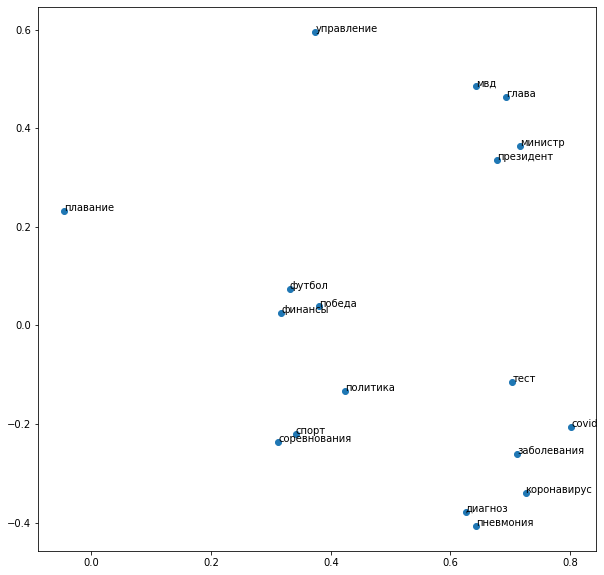

In [ ]:
# SkipGram
clustering_words = ['коронавирус', 'covid', 'тест', 'диагноз', 'пневмония', 'заболевания', 'футбол', 'спорт', 'плавание', 'соревнования', 'победа', 'политика', 'президент', 'министр', 'финансы', 'управление', 'глава', 'мвд']
skip_vecs = skip.get_vectors(*clustering_words)
print("Визуализация тематических кластеров векторов слов")

fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
projections = TruncatedSVD().fit_transform(skip_vecs)
x = projections[:, 0]
y = projections[:, 1]
ax.scatter(x, y)
for cur_x, cur_y, cur_label in zip(x, y, clustering_words):
    ax.annotate(cur_label, (cur_x, cur_y))

Визуализация тематических кластеров векторов слов


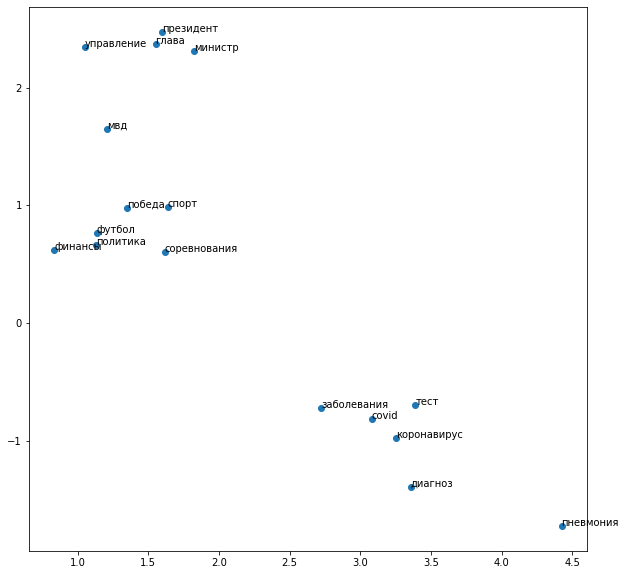

In [ ]:
# CBOW
cbow_vecs = cbow.get_vectors(*clustering_words)
print("Визуализация тематических кластеров векторов слов")

fig, ax = plt.subplots()
fig.set_size_inches((10, 10))
projections = TruncatedSVD().fit_transform(cbow_vecs)
x = projections[:, 0]
y = projections[:, 1]
ax.scatter(x, y)
for cur_x, cur_y, cur_label in zip(x, y, clustering_words):
    ax.annotate(cur_label, (cur_x, cur_y))